# MOVIE RECOMMENDATION
### These scripts use clustering in order to create a movie recommendation system.

## 1) PREPROCESSING

### First rows of the file movies.csv:

In [1]:
import pandas
df = pandas.read_csv('input/MovieLens/movies.csv')
df.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### First rows of the file ratings.csv:

In [2]:
import pandas
df = pandas.read_csv('input/MovieLens/ratings.csv')
df.head()


,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [3]:
# PYTHON'S VERSION USED: 3.8.2
# APACHE SPARK NEED TO BE INSTALLED IN THE DEVICE
import findspark
findspark.init("/usr/local/spark")
from pyspark.sql import SparkSession
from pyspark.sql.functions import round
# SPARK SESSION
spark = SparkSession.builder.appName("Preprocessing").getOrCreate()
# CSV MOVIES IMPORT
movies = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("input/MovieLens/movies.csv*"))
# CSV RATINGS IMPORT
ratings = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("input/MovieLens/ratings.csv*"))
# JOIN OF THE TWO DATAFRAMES
df = ratings.join(movies, on=["movieId"], how="left")
# CREATION OF A DATAFRAME WITH ONLY 1 COLUMN: ('UserID'), WE WILL USE IT LATER
df2 = df.select("UserId").distinct().orderBy("UserId")
# LIST OF THE GENRES
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Mystery",
    "Musical",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
# CREATION OF A DATAFRAME WITH COLUMN ('UserID')
# AND WITH 1 COLUMN FOR EVERY GENRE'S AVERAGE RATING
for genre in genres:
    df1 = df.filter(df.genres.contains(genre))
    df2 = df2.join(
        df1.groupBy("userId").avg("rating").withColumnRenamed(
            "avg(rating)", "avg_" + str(genre)),
        on=["UserId"],
        how="left",
    )
# REPLACE THE NULL VALUES IN THE DATAFRAME WITH ZERO
df2 = df2.na.fill(0)
# ROUND THE VALUES
df2 = df2.select([round(c, 2).alias(c) for c in df2.columns])
# ORDER THE DATAFRAME BY 'UserID'
df3 = df2.orderBy("UserId")
# SAVE THE DATAFRAME IN A LOCAL FOLDER
# TO USE IN THE NEXT .PY FILES (Elbow Method.py, Clustering.py AND Test.py)
df3.coalesce(1).write.option("header", "true").csv("output/preprocessing")


### First rows of the .csv output of preprocessing:

In [4]:
import pandas
df = pandas.read_csv(
    'output/preprocessing/part-00000-f421c44a-9e32-4574-afea-9203ec649f54-c000.csv'
)
df.head()


,UserId,avg_Action,avg_Adventure,avg_Animation,avg_Children,avg_Comedy,avg_Crime,avg_Documentary,avg_Drama,avg_Fantasy,avg_Film-Noir,avg_Horror,avg_Mystery,avg_Musical,avg_Romance,avg_Sci-Fi,avg_Thriller,avg_War,avg_Western
0,1,2.88,1.50,0.00,0.00,3.75,3.00,0.00,3.67,4.50,0.0,2.25,0.00,0.00,4.00,2.75,2.64,0.00,4.00
1,2,3.50,3.50,0.00,0.00,3.61,3.50,0.00,3.81,0.00,0.0,4.00,0.00,4.00,3.70,3.50,3.50,3.00,0.00
2,3,5.00,4.00,0.00,4.00,3.50,3.50,0.00,3.63,0.00,0.0,3.00,3.50,0.00,0.00,0.00,3.67,5.00,0.00
3,4,3.62,3.48,3.55,2.47,2.90,3.79,3.42,3.60,3.41,5.0,3.45,3.82,2.55,3.21,3.47,3.73,3.96,2.85
4,5,4.27,4.29,0.00,0.00,4.26,4.34,4.50,4.31,4.50,4.5,0.00,4.32,0.00,4.50,4.50,4.25,4.38,4.50


## 2) ELBOW METHOD
### Used to determine the optimal number of clusters to use.

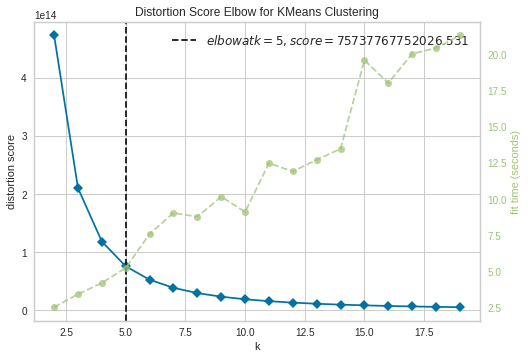

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# IMPORTING THE DATAFRAME OBTAINED FROM Preprocessing.py
# Change it according to the name of the file
data = pd.read_csv(
    "output/preprocessing/part-00000-f421c44a-9e32-4574-afea-9203ec649f54-c000.csv",
    sep=",",
    header=1,
)
X = data.iloc[:, :].values
# GRAPHICAL VIEW OF THE ELBOW METHOD
model = KMeans()  # Using KMeans as model
# Range of the Clusters between 2 and 20
visualizer = KElbowVisualizer(model, k=(2, 20))
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure


## 3) CLUSTERING

In [6]:
import findspark
findspark.init("/usr/local/spark")
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
# SPARK SESSION (THE config. IS JUST TO RESOLVE A MINOR WARNING)
spark = (SparkSession.builder.appName("Clustering").config(
    "spark.sql.debug.maxToStringFields", 1000).getOrCreate())
# NUMER OF CLUSTERS OBTAINED FROM THE FILE Elbow Method.py
k = 5
# IMPORTING THE DATAFRAME OBTAINED FROM Preprocessing.py
df = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("output/preprocessing/*"))
# VECTOR ASSEMBLER
vecAssembler = VectorAssembler(
    inputCols=[
        "avg_Action",
        "avg_Adventure",
        "avg_Animation",
        "avg_Children",
        "avg_Comedy",
        "avg_Crime",
        "avg_Documentary",
        "avg_Drama",
        "avg_Fantasy",
        "avg_Film-Noir",
        "avg_Horror",
        "avg_Mystery",
        "avg_Musical",
        "avg_Romance",
        "avg_Sci-Fi",
        "avg_Thriller",
        "avg_War",
        "avg_Western",
    ],
    outputCol="features",
)
df = vecAssembler.transform(df)
df = df.select("UserId", "features")
# CREATION OF THE KMEANS MODEL
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(df.select("features"))
# APPLYING THE MODEL TO THE DATAFRAME
df2 = model.transform(df)
# REMOVING ALL THE 'features' COLUMNS FROM THE DATAFRAME
df3 = df2.drop("features")
# ORDER THE DATAFRAME BY 'UserID'
df4 = df3.orderBy("UserId")
# SAVE THE DATAFRAME IN A LOCAL FOLDER
# TO USE IN THE NEXT .PY FILES (Top Clusters.py)
df4.coalesce(1).write.option("header", "true").csv("output/clustering")


### First rows of the .csv output of clustering:

In [7]:
import pandas
df = pandas.read_csv(
    'output/clustering/part-00000-fee50640-578f-4738-9481-36216fe50119-c000.csv'
)
df.head()


,UserId,prediction
0,1,0
1,2,0
2,3,0
3,4,4
4,5,4


## 4) TOP MOVIES IN THE CLUSTERS

In [8]:
import findspark
findspark.init("/usr/local/spark")
from pyspark.sql import functions as func
from pyspark.sql import SparkSession
# SPARK SESSION
spark = SparkSession.builder.appName("Top Clusters").getOrCreate()
# NUMER OF CLUSTERS OBTAINED FROM THE FILE Elbow Method.py
k = 5
# MINIMUM NUMBER OF RATINGS OF A MOVIE
# MOVIE WON'T BE CONSIDERED IF IT HAS LESS RATINGS THAN THIS NUMBER
nr = 100
# NUMBER OF TOP MOVIES FOR EACH CLUSTER 
# ANY CLUSTER WILL HAVE A RANK OF THE TOP 100 RATED MOVIES
m = 100
# CSV RATINGS IMPORT
ratings = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("input/MovieLens/ratings.csv*"))
# IMPORTING THE DATAFRAME OBTAINED FROM Clustering.py
cluster = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("output/clustering/*"))
# DO THESE THINGS FOR EVERY CLUSTERS
for i in range(k):
    # SELECT ONLY THE 'UserID' RELATED TO THE CLUSTER k
    # CREATE THE DATAFRAME (WITH ONLY 1 COLUMN)
    df = cluster.filter(cluster.prediction.contains(i)).select("UserId")
    # JOIN THE DATAFRAME WITH THE ratings.csv DATAFRAME
    # ONLY JOIN THE RELATED 'UserID' OF THE CLUSTER
    df = df.join(ratings, on=["UserId"], how="left")
    # SELECT ATTRIBUTES 'movieId' and 'rating'
    # GROUP BY 'movieID' WITH THEIR AVERAGE RATING AND NUMBER OF VOTES
    df = (df.select("movieId",
                    "rating").groupBy("movieId").agg(func.mean("rating"),
                                                     func.count("rating")))
    # DELETE THE MOVIES WIH LESS THAN nr NUMBER OF VOTES
    df = df.filter(func.col("count(rating)") >= nr)
    # ROUND THE 'rating' COLUMN AND RENAME THE NUMBER OF VOTES COLUMN
    df = df.withColumn("rating", func.round(df["avg(rating)"],
                                            2)).withColumnRenamed(
                                                "count(rating)", "votes")
    # ORDER THE MOVIES BY THEIR RATINGS AND BY THEIR NUMBER OF VOTES
    df = df.select("movieId", "rating", "votes").orderBy(["rating", "votes"],                                                      ascending=0)
    # ONLY SHOW THE TOP m MOVIES
    df = df.limit(m)
    # SAVE THE DATAFRAME IN A LOCAL FOLDER
    # TO USE IN THE NEXT .PY FILE (Test.py)
    df.coalesce(1).write.option("header",
                                "true").csv("output/top100/" + str(i) + "/")


### First rows of the .csv containing the top movies of first cluster:

In [9]:
import pandas
df = pandas.read_csv(
    'output/top100/0/part-00000-b4561564-b281-4684-8e81-33fef96548bb-c000.csv'
)
df.head()


,movieId,rating,votes
0,318,4.44,13223
1,858,4.36,7812
2,1221,4.30,4335
3,50,4.27,6674
4,2959,4.26,7597


## 5) CONVERTING THE .CSV FILE IMPORTED FROM IMDB IN A SUITABLE FORMAT

### First rows of the file links.csv

In [10]:
import pandas
df = pandas.read_csv('input/MovieLens/links.csv')
df.head()


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### First rows of the personal ratings file imported from IMDb's site:

In [11]:
import pandas
df = pandas.read_csv("input/IMDb/DeFrancesco.csv")
df.head()


,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt0102926,8,2020-04-10,The Silence of the Lambs,https://www.imdb.com/title/tt0102926/,movie,8.6,118,1991,"Crime, Drama, Thriller",1201513,1991-01-30,Jonathan Demme
1,tt0111161,10,2020-04-08,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142,1994,Drama,2215339,1994-09-10,Frank Darabont
2,tt1130884,8,2020-04-10,Shutter Island,https://www.imdb.com/title/tt1130884/,movie,8.1,138,2010,"Mystery, Thriller",1065009,2010-02-13,Martin Scorsese
3,tt0120737,7,2020-04-10,The Lord of the Rings: The Fellowship of the Ring,https://www.imdb.com/title/tt0120737/,movie,8.8,178,2001,"Action, Adventure, Drama, Fantasy",1583928,2001-12-10,Peter Jackson
4,tt1345836,9,2020-04-10,The Dark Knight Rises,https://www.imdb.com/title/tt1345836/,movie,8.4,164,2012,"Action, Adventure",1450651,2012-07-16,Christopher Nolan


In [12]:
import findspark
findspark.init("/usr/local/spark")
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
import matplotlib.pyplot as plt
# SPARK SESSION (THE config. IS JUST TO RESOLVE A MINOR WARNING)
spark = (SparkSession.builder.appName("IMDb Converter").config(
    "spark.sql.debug.maxToStringFields", 1000).getOrCreate())
# IMPORT OF THE IMDB .csv PERSONAL FILE
user = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("input/IMDb/DeFrancesco.csv"))
# CSV LINKS IMPORT
# THE FILE THAT CONTAINS RELATION BETWEEN IMDB AND MOVIE LENS MOVIES
links = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("input/MovieLens/links.csv"))
# ADDITIONAL OPERATIONS TO MAKE POSSIBILE THE UNION
user = user.withColumn("imdbId", func.substring("Const", 3, 8))
user = user.withColumn("rating", (func.col("Your Rating")) / 2)
# JOIN THE DATAFRAME WITH THE DATAFRAME top
user = user.join(links, on=["imdbId"], how="inner")
# CRATE THE COLUMN 'userId' WITH ALL 'user' AS VALUE FOR EVERY RECORDS
user = user.withColumn("userId", func.lit("user"))
# SELECT JUST THESE ATTRIBUTES
user = user.select("userId", "movieId", "rating")
# SAVE THE DATAFRAME IN A LOCAL FOLDER
# TO USE IN THE NEXT .PY FILE (Test.py)
user.coalesce(1).write.option("header", "true").csv("output/user")


### First rows of the personal ratings file converted in a suitable format to fit the clustering model:

In [13]:
# SHOWING THE FIRST ROWS OF THE CREATED .csv FILE
import pandas
df = pandas.read_csv(
    'output/user/part-00000-4874e269-2e7d-4fb0-ab88-82a8b68ec40f-c000.csv'
)
df.head()


,userId,movieId,rating
0,user,318,5.0
1,user,593,4.0
2,user,1258,3.5
3,user,1274,3.0
4,user,4993,3.5


## 6) TESTING THE SYSTEM ON MY PERSONAL PROFILE

In [14]:
import findspark
findspark.init("/usr/local/spark")
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as func
# SPARK SESSION (THE config. IS JUST TO RESOLVE A MINOR WARNING)
spark = (SparkSession.builder.appName("Test").config(
    "spark.sql.debug.maxToStringFields", 1000).getOrCreate())
# NUMER OF CLUSTERS OBTAINED FROM THE FILE Elbow Method.py
k = 5
# NUMBER OF MOVIES TO RECOMMEND TO THE USER
nm = 10
# IMPORTING THE DATAFRAME OBTAINED FROM Preprocessing.py
df = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("output/preprocessing/*"))
# IMPORTING THE DATAFRAME OBTAINED FROM IMDB_to_ML.py
user = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("output/user/*"))
# CSV MOVIES IMPORT
movies = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("input/MovieLens/movies.csv*"))
# JOIN THE DATAFRAME user ON 'movieId' WITH THE movies.csv FILE
user = user.join(movies, on=["movieId"], how="left")
# CREATION OF A DATAFRAME WITH ONLY 1 COLUMN: ('UserID'), WE WILL USE IT LATER
user2 = user.select("UserId").distinct().orderBy("UserId")
# LIST OF THE GENRES
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Mystery",
    "Musical",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
# CREATION OF A DATAFRAME WITH COLUMN ('UserID')
# AND WITH 1 COLUMN FOR EVERY GENRE'S AVERAGE RATING
for genre in genres:
    user1 = user.filter(user.genres.contains(genre))
    user2 = user2.join(
        user1.groupBy("userId").avg("rating").withColumnRenamed(
            "avg(rating)", "avg_" + str(genre)),
        on=["userId"],
        how="left",
    )
# IF THE USER DIDN'T DO AT LEAST ONE RATING FOR EVERY GENRE
# THIS RESOLVE THE PROBLEM
user2 = user2.na.fill(0)
# VECTOR ASSEMBLER
vecAssembler = VectorAssembler(
    inputCols=[
        "avg_Action",
        "avg_Adventure",
        "avg_Animation",
        "avg_Children",
        "avg_Comedy",
        "avg_Crime",
        "avg_Documentary",
        "avg_Drama",
        "avg_Fantasy",
        "avg_Film-Noir",
        "avg_Horror",
        "avg_Mystery",
        "avg_Musical",
        "avg_Romance",
        "avg_Sci-Fi",
        "avg_Thriller",
        "avg_War",
        "avg_Western",
    ],
    outputCol="features",
)
df = vecAssembler.transform(df)
user2 = vecAssembler.transform(user2)
df = df.select("UserId", "features")
user2 = user2.select("UserId", "features")
# CREATION OF THE KMEANS MODEL
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(df.select("features"))
# APPLYING THE MODEL TO THE DATAFRAME
user2 = model.transform(user2)
# PRINT THE CLUSTER RELATED TO THE USER
ncluster = user2.collect()[0][2]
print("\n" + "______________" + "\n" + "\n" + "Cluster N: " +
      str(ncluster + 1) + "\n" + "______________" + "\n")
# IMPORTING THE DATAFRAME OBTAINED FROM Top Clusters.py
# THE DATAFRAME RELATED TO THE USER CLUSTER
top = (spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("output/top100/" + str(ncluster) + "/*"))
# SELECT JUST THE RELATED ATTRIBUTES
user3 = user.select("movieId", "userId")
# JOIN THE DATAFRAME user3 ON 'movieId' WITH THE DATAFRAME top
top = top.join(user3, on=["movieId"], how="left").orderBy("movieId")
# REPLACE THE NULL VALUES IN THE DATAFRAME WITH 'ok'
top = top.na.fill("ok")
# SELECT JUST THE RECORD WITH THE NULL VALUE
# SO WE CAN JUST RECOMMEND THE MOVIE THAT THE USED HASN'T SEE YET
top = top.filter(func.col("userId") == "ok")
# ORDER THE DATAFRAME AND SELECT JUST THE FIRST nm MOVIES
top = top.orderBy("rating", ascending=0).limit(nm)
# JOIN THE DATAFRAME top ON 'movieId' WITH THE DATAFRAME movies
top = top.join(movies, on=["movieId"], how="left")
# CREATE A NEW COLUMN, THE PERCENTAGE OF RECCOMENDATION
# BASED ON THE AVERAGE RATINGS OF THE CLUSTER'S USERS
top = top.withColumn(
    "Compatibility", func.format_string("%2.0f%%",
                                        func.col("rating") / 5 * 100))
# RENAME THE 'title' COLUMN
top = top.withColumnRenamed("title", "Suggested Movies")
# RENAME THE 'genres' COLUMN
top = top.withColumnRenamed("genres", "Genres")
# SELECT JUST THESE ATTRIBUTES
top = top.select("Suggested Movies", "Compatibility", "Genres")
# PRINT THE DATAFRAME
# truncate=False SO WE CAN SEE THE COMPLETE NAME OF THE MOVIES
top.show(truncate=False)



______________

Cluster N: 2
______________

+-------------------------------------------------------+-------------+------------------------------------+
|Suggested Movies                                       |Compatibility|Genres                              |
+-------------------------------------------------------+-------------+------------------------------------+
|Planet Earth II (2016)                                 |91%          |Documentary                         |
|Planet Earth (2006)                                    |91%          |Documentary                         |
|Black Mirror: White Christmas (2014)                   |91%          |Drama|Horror|Mystery|Sci-Fi|Thriller|
|Schindler's List (1993)                                |88%          |Drama|War                           |
|Piper (2016)                                           |88%          |Animation                           |
|Knockin' on Heaven's Door (1997)                       |88%          |Action|Come